# Control de plagas con umbral

En manejo integrado de plagas (IPM), el **umbral de acción** $T$ define cuándo vale la pena **activar control**.  
- Si la población/daño $N_t$ **no alcanza** $T$, se **observa y registra** (sin control).  
- Si $N_t \ge T$, se **aplica control** (remoción, cosecha, biopesticida, etc.).

**Ejemplos reales**
- **Áfidos en hortalizas**: activar control si se superan cierto número de áfidos por hoja/trampa por semana.  
- **Mosquitos *Aedes***: activar control focal (ovitrampas, larvicida) cuando los índices larvarios superan $T$.

En este cuaderno modelaremos una plaga con **crecimiento logístico** (capacidad de carga $K$, tasa $r$) y una **regla de umbral** $(T,\eta)$ que activa un control proporcional: al activarse, se elimina una fracción $\eta\in(0,1)$ de la población.

> **Variables y parámetros**
> - $N_t$: población de la plaga en el periodo $t$.  
> - $r>0$: tasa intrínseca de crecimiento por periodo.  
> - $K>0$: capacidad de carga.  
> - $T>0$: umbral de activación del control.  
> - $\eta\in(0,1)$: fracción removida **cuando** el control se activa.  
> - $N_0$: condición inicial.  

## Dinámica base (logística discreta)
Usaremos como base el crecimiento logístico:
$$
G(N) \;=\; N + r\,N\left(1 - \frac{N}{K}\right).
$$
El control por umbral se modela como una **regla por tramos** que modifica la transición $N_t \to N_{t+1}$ **solo cuando** $N_t\ge T$.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Código común para los tres modelos
def Calcular_metricas(series: np.ndarray, threshold: float, tail_frac: float = 0.3):
    """
    Calcula métricas simples sobre la serie simulada.
    
    Parámetros
    ----------+-2
    series : np.ndarray
        Serie N_t de longitud Tpasos+1 (t = 0..Tpasos).
    threshold : float
        Umbral T usado para contar activaciones.
    tail_frac : float, opcional (default=0.3)
        Fracción final de la serie para el promedio 'en régimen'.
    
    Returns
    -------
    dict
        {'promedio_final': float, 'min_final': float, 'max_final': float, '% activaciones': float}
    """
    tail = series[int((1-tail_frac)*len(series)):]
    activaciones = np.mean(series[:-1] >= threshold) * 100.0
    return {
        "promedio_final": float(np.mean(tail)),
        "min_final": float(np.min(tail)),
        "max_final": float(np.max(tail)),
        "% activaciones": float(activaciones)
    }

def graficar_trayectoria(series: np.ndarray, params: list, title: str = "Serie temporal"):
    """
    Grafica la serie N_t y muestra líneas horizontales de K y T (si T es finito).
    *No* establece estilos ni colores específicos.
    """
    plt.figure()
    plt.plot(series, label="N_t")
    if params[2] < 1e8:
        plt.axhline(params[2], linestyle="--", label="Umbral T")
    plt.axhline(params[1], linestyle=":", label="Capacidad K")
    plt.title(title)
    plt.xlabel("t (periodos)")
    plt.ylabel("Población N_t")
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Modelo A** – *solo control* (golpe sin crecimiento en ese periodo)
**Regla:**  
$$
N_{t+1}=\begin{cases}
G(N_t), & \text{si } N_t < T,\\
(1-\eta)\,N_t, & \text{si } N_t \ge T.
\end{cases}
$$

**Interpretación:** cuando se activa el control, el periodo queda ocupado por la intervención y **no se contabiliza crecimiento** ese mismo periodo.

### Tarea
1. Implementa las funciones siguientes (usa las **firmas** y **docstrings** provistas).  
2. Simula **80 periodos** con los **parámetros sugeridos** y **grafica** la serie.  
3. Reporta:  
   - **Promedio final** (media del 30% final de la serie).  
   - **% de activaciones** (proporción de periodos con $N_t \ge T$).  
4. **Interpreta**: ¿observas un patrón tipo *serrucho* alrededor del umbral? ¿Cómo influye $\eta$ en la amplitud?

In [8]:

# === Plantillas a completar (Modelo A) ===

def G(N: float, r: float, K: float) -> float:
    """
    Devuelve un paso de crecimiento logístico: G(N) = N + r*N*(1 - N/K).
    
    Parámetros
    ----------
    N : float
        Población actual N_t (debe ser no negativa).
    r : float
        Tasa intrínseca de crecimiento por periodo (r > 0).
    K : float
        Capacidad de carga (K > 0).
    
    Returns
    -------
    float
        Población al final del crecimiento (sin control aplicado aún).
    """
    # TODO: Implementar la fórmula logística
    return N + r * N * (1 - N / K)


def paso_A(Nt: float, params: list) -> float:
    """
    Modelo A: umbral con 'solo control' (sin crecimiento en ese periodo cuando N_t >= T).
    
    Reglas
    ------
    - Si N_t < T: aplicar crecimiento logístico G(N_t).
    - Si N_t >= T: aplicar control instantáneo N_{t+1} = (1 - eta)*N_t.

    Parámetros
    ----------
    Nt : float
        Población actual N_t (debe ser no negativa).
    params : list
        Contiene [r, K, T, eta]:
        - r : tasa intrínseca de crecimiento por periodo (r > 0).
        - K : capacidad de carga (K > 0).  
        - T : umbral de activación del control (T > 0).
        - eta : fracción de reducción instantánea al activar el control (0 < eta < 1).
    
    Precondiciones
    --------------
    - r, K > 0
    - 0 < eta < 1
    - T > 0

    Returns
    -------
    float
        Valor de N_{t+1} tras aplicar la regla del modelo A.
    """
    # TODO: Implementar la regla por tramos
    r, K, T, eta = params
    if Nt < T:
        return G(Nt, r, K)
    else:
        return (1 - eta) * Nt


def simular(model_step, params: list) -> np.ndarray:
    """
    Simula Tpasos periodos usando una función de transición de un paso: model_step(N_t, params).
    
    Parámetros
    ----------
    model_step : callable
        Función de un paso (Nt: float, params: list) -> float.
    params : list
        Contiene r, K, T, eta, N0, Tpasos.
    
    Returns
    -------
    np.ndarray
        Serie N_t de longitud Tpasos+1 (incluye N_0).
    """
    # TODO: Implementar el bucle de simulación (y forzar no-negatividad)
    r, K, T, eta = params[0:4]
    N_t = params[4]  # N0
    Tpasos = params[5]
    series = np.zeros(Tpasos + 1)
    series[0] = N_t

    for t in range(1, Tpasos + 1):
        N_t = model_step(N_t, params[0:4])
        N_t = max(0, N_t)  # Forzar no-negatividad
        series[t] = N_t

    return series


def contar_activaciones(series: np.ndarray, T: float) -> int:
    """
    Cuenta cuántos periodos activan el control, es decir, cuántos t cumplen N_t >= T.
    
    Nota: evalúa sobre N_t (t=0..T-1), no incluye el último valor N_{Tpasos}.
    """
    # TODO: Implementar el conteo
    # Usa np.sum con una condición booleana o un bucle explícito
    return np.sum(series[:-1] >= T)


### Parámetros (Modelo A)
Usa: $r=0.8$, $K=1000$, $T=600$, $\eta=0.30$, $N_0=120$, $T_{pasos}=80$.

**Preguntas**
- ¿Cuál es el **promedio final** y el **% de activaciones**?  
- Describe cualitativamente la forma de la serie. ¿Se acerca a un ciclo en torno a $T$?  
- ¿Qué cambia si duplicas $\eta$ (p. ej., 0.6) manteniendo $T$ fijo?

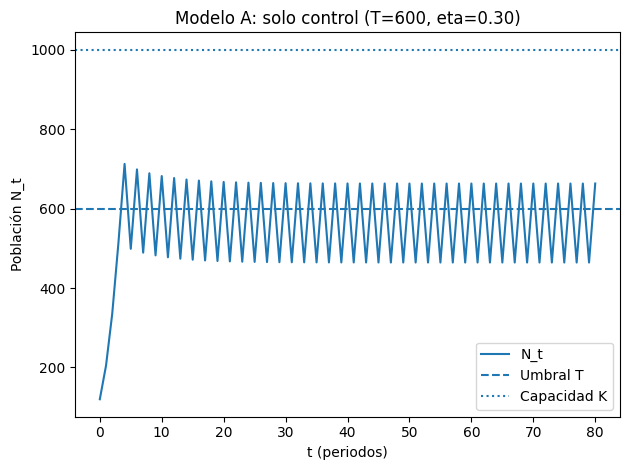

Métricas Modelo A: {'promedio_final': 567.7596573724405, 'min_final': 464.2861689145406, 'max_final': 663.2831309447769, '% activaciones': 47.5}
Activaciones (Modelo A): 38


In [9]:
# === Ejecución (completa tras implementar las funciones) ===

params_A = [0.8, 1000, 600, 0.30, 120, 80]

N_A = simular(paso_A, params_A)
graficar_trayectoria(N_A, params_A, title="Modelo A: solo control (T=600, eta=0.30)")

mA = Calcular_metricas(N_A, params_A[2], tail_frac=0.3)
activ_A = contar_activaciones(N_A, params_A[2])

print("Métricas Modelo A:", mA)
print("Activaciones (Modelo A):", activ_A)

## **Modelo B** – *crecer y luego controlar* (harvest after growth)
**Regla:**  
$$
N_{t+1}=\begin{cases}
G(N_t), & \text{si } N_t < T,\\
(1-\eta)\,G(N_t), & \text{si } N_t \ge T.
\end{cases}
$$

**Interpretación:** la población crece dentro del periodo y **al final** se descuenta una fracción $\eta$.  
Para $\eta < \frac{r}{1+r}$ puede existir un **punto fijo positivo** en la zona con control activo.

### Tarea
- Implementa `step_B` (reutiliza `G`, `simular`, `contar_activaciones`).  
- Simula con los **mismos parámetros** del Modelo A para comparar.  
- Reporta **promedio final** y **% de activaciones**.  
- **Compara** con el Modelo A: ¿el promedio es mayor? ¿cambia la frecuencia de activación?


In [10]:

# === Plantilla a completar (Modelo B) ===

def step_B(Nt: float, params: list) -> float:
    """
    Modelo B: crecer y luego controlar.
    
    Reglas
    ------
    - Si N_t < T: N_{t+1} = G(N_t).
    - Si N_t >= T: N_{t+1} = (1 - eta) * G(N_t).
    """
    # TODO: Implementar la regla por tramos
    r, K, T, eta = params
    if Nt < T:
        return G(Nt, r, K)
    else:
        return (1 - eta) * G(Nt, r, K)

### Ejecución y preguntas (Modelo B)
- Usa los mismos parámetros del Modelo A.  
- ¿Existe un **equilibrio** aparente por encima de $T$? ¿Cómo se compara con el Modelo A?


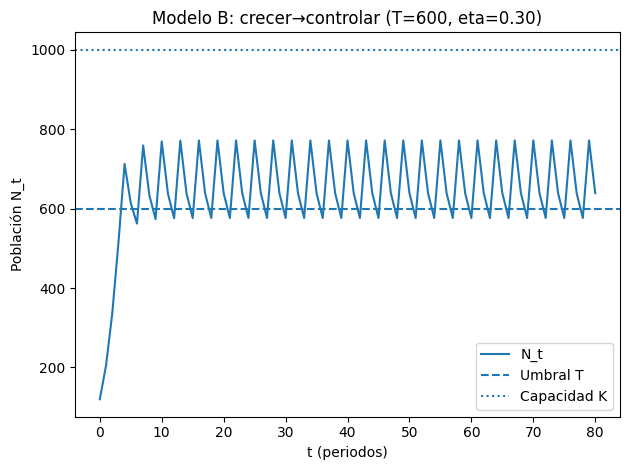

Métricas Modelo B: {'promedio_final': 661.3969260063245, 'min_final': 576.4065357208315, 'max_final': 771.736168760151, '% activaciones': 63.74999999999999}
Activaciones (Modelo B): 51


In [11]:
params_B = params_A  # misma comparación

N_B = simular(step_B, params_B)
graficar_trayectoria(N_B, params_B, title="Modelo B: crecer→controlar (T=600, eta=0.30)")

mB = Calcular_metricas(N_B, params_B[2], tail_frac=0.3)
activ_B = contar_activaciones(N_B, params_B[2])

print("Métricas Modelo B:", mB)
print("Activaciones (Modelo B):", activ_B)

## **Modelo C** – *controlar y luego crecer* (harvest before growth)
**Regla:**  
$$
N_{t+1}=\begin{cases}
G(N_t), & \text{si } N_t < T,\\
G\big((1-\eta)\,N_t\big), & \text{si } N_t \ge T.
\end{cases}
$$

**Interpretación:** primero se descuenta $\eta$ y **después** el remanente crece ese mismo periodo.  
Cuando existe equilibrio positivo bajo control, suele ser **más alto** que en el Modelo B: $N^{*}_C=\dfrac{N^{*}_B}{1-\eta}$.

### Tarea
- Implementa `step_C`.  
- Simula con los **mismos parámetros** y compara con A y B.  
- Reporta métricas y **discute**: ¿las oscilaciones son mayores que en B? ¿Por qué?


In [12]:

# === Plantilla a completar (Modelo C) ===

def step_C(Nt: float, params: list) -> float:
    """
    Modelo C: controlar y luego crecer.
    
    Reglas
    ------
    - Si N_t < T: N_{t+1} = G(N_t).
    - Si N_t >= T: N_{t+1} = G((1 - eta) * N_t).
    """
    # TODO: Implementar la regla por tramos
    r, K, T, eta = params
    if Nt < T:
        return G(Nt, r, K)
    else:
        return G((1 - eta) * Nt, r, K)

### Ejecución y preguntas (Modelo C)
- Usa los mismos parámetros del Modelo A.  
- Compara **promedio final**, **% de activaciones** y la **amplitud** de las oscilaciones.


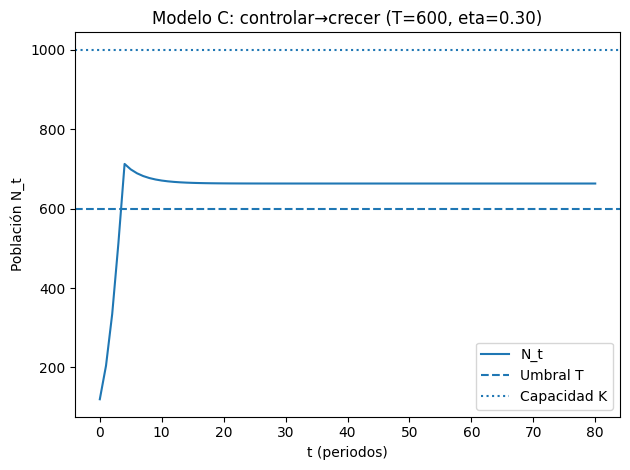

Métricas Modelo C: {'promedio_final': 663.2653072136054, 'min_final': 663.2653061276081, 'max_final': 663.2653132187846, '% activaciones': 95.0}
Activaciones (Modelo C): 76


In [13]:
params_C = params_A  # misma comparación

N_C = simular(step_C, params_C)
graficar_trayectoria(N_C, params_C, title="Modelo C: controlar→crecer (T=600, eta=0.30)")

mC = Calcular_metricas(N_C, params_C[2], tail_frac=0.3)
activ_C = contar_activaciones(N_C, params_C[2])

print("Métricas Modelo C:", mC)
print("Activaciones (Modelo C):", activ_C)
